# Training + Testing Landslide Prediction

Created: <b>Trong-An Bui</b> <br>
Organization: <b>ViP Lab - National Chi Nan University, Taiwan</b> <br/>
Email: trongan93@gmail.com <br/>
Project: <b>AI Cube Satellite</b> <br/>
Advisor: <b>Prof. Pei-Jun Lee</b>

## Imports

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#os.environ["AUTOGRAPH_VERBOSITY"] = "10"
#os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

print("py", python_version())
print("tf", tf.__version__)
print("keras", tf.keras.__version__)
mem = psutil.virtual_memory()
print("mem", mem.total/1024/1024)
cpu = mp.cpu_count()
print("cpu", cpu)

%system nvidia-smi
#%system rocm-smi

py 3.7.7
tf 2.3.0
keras 2.4.0
mem 128555.12109375
cpu 40


['Sat Sep  5 08:09:42 2020       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Quadro RTX 4000     Off  | 00000000:1D:00.0 Off |                  N/A |',
 '| 30%   56C    P0    37W / 125W |      0MiB /  7982MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '|   1  Quadro RTX 4000     Off  | 00000000:1E:00.0 Off |                  N/A |',
 '| 30%   51C    P0    37W / 125W |      0MiB /  7982MiB |      0%      Default |',
 '+-------------------------------+-----

## Variables

In [2]:
epochs = 250
batch_size = 150
testsplit = .2
targetx = 224
targety = 224
learning_rate = 0.0001
classes = 2
seed = random.randint(1, 1000)

data_dir = "../LandslideDataset/"
resized_dir = "./img_data/resized/"
test_dir = "./img_data/test/"

## Crop images using provided annotations

## Keras image data readers

In [3]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        validation_split=testsplit,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        resized_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
        subset="training"
)

test_generator = datagen.flow_from_directory(
        resized_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
        subset="validation"
)

Found 977 images belonging to 2 classes.
Found 243 images belonging to 2 classes.


## Sample image

./img_data/resized/Positive/3845306_landsat_8_rgb.tif


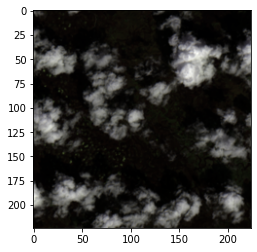

In [4]:
img = train_generator.filepaths[np.random.random_integers(low=0, high=train_generator.samples)]
print(img)
img = mpimg.imread(img)
plt.imshow(img)

### GPU configuration

In [5]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 8


## Keras callbacks

In [6]:
checkpoint = ModelCheckpoint('landslide_classifier_efficientnet.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

#https://github.com/keras-team/keras/issues/3358
tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=50,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

## Define new top layers and compile model

In [7]:
with strategy.scope():
#     base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = Dropout(rate = .2)(x)
    x = BatchNormalization()(x)
    x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(seed), bias_initializer='zeros')(x)
    # x = Dropout(rate = .2)(x)
    x = BatchNormalization()(x)
    predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    optimizer = Adam(lr=learning_rate)
    # optimizer = RMSprop(lr=learning_rate)

    loss = "categorical_crossentropy"
    # loss = "kullback_leibler_divergence"

    for layer in model.layers:
        layer.trainable = True
    # for layer in model.layers[-2:]:
    #     layer.trainable = True

    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=["accuracy"])

    model.summary()
    # for i, layer in enumerate(model.layers):
    #     print(i, layer.name, layer.trainable)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Fit model

In [8]:
%%time

params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator), 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=epochs,
                                callbacks=[reducelr, earlystop, lambdacb, tensorboard, checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Learning rate:  1e-04
Epoch 1/250
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 219 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 219 all-reduces with algorithm = nccl, num_packs = 1
1/7 [===>..........................] - ETA: 0s - loss: 0.9618 - accuracy: 0.4667WARNING:tensorflow:From /home/jupyter_user/anaconda3/envs/viplab-gpu/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
7/7 [==============================] - ETA: 0s - loss: 0.8946 - accuracy: 0.5343
Epoch 00001: val_accuracy improved from -inf to 0.55556, saving model to landslide_classifier_efficientnet.h5
7/7 [==============================] - 29s 4s/step 

## Training and test loss/accuracy graphs

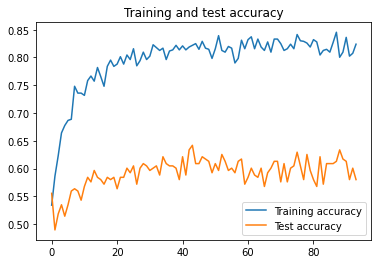

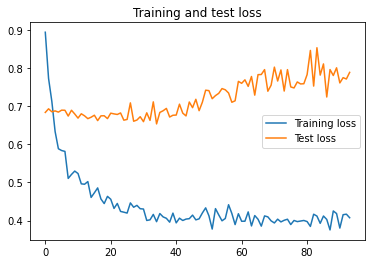

In [9]:
# plt.subplot(2, 1, 1)
plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.legend()
plt.show()

# plt.subplot(2, 1, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()

plt.show()

## Sample prediction

predict with test number:  110
./img_data/resized/Negative/3838389_sentinel_2_rgb.tif
0.66556025   :   (1, 'Positive')
0.33443972   :   (0, 'Negative')


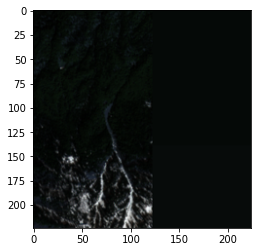

In [10]:
# Randomly test an image from the test set

# model.load_weights('dog_breed_classifier.h5')

imageno=np.random.random_integers(low=0, high=test_generator.samples)
print('predict with test number: ', imageno)

name = test_generator.filepaths[imageno]
print(name)
plt.imshow(mpimg.imread(name))

img = Image.open(test_generator.filepaths[imageno]).resize((targetx, targety))
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

## Sample for paper test

0.66556025   :   (1, 'Positive')
0.33443972   :   (0, 'Negative')


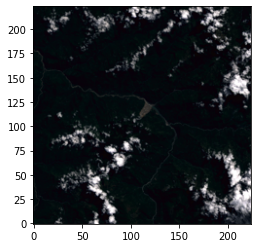

In [11]:
# path for landslide 
#./data/reized/WithLandslide/25_94_Large_cropped_6.TIF
# ./data/reized/WithLandslide/44_-123_Large_cropped_4.TIF
# ./imgtest/27.770733_85.868467_VERY_LARGE_cropped_LC08_L1TP_141041_20130915_20170502_01_T1.TIF
# ./imgtest/27.770733_85.868467_VERY_LARGE_cropped_LC08_L1TP_141041_20140918_20170419_01_T1.TIF
img_test = Image.open(test_dir + "27.770733_85.868467_VERY_LARGE_cropped_LC08_L1TP_141041_20140918_20170419_01_T1.TIF").resize((targetx, targety))
plt.imshow(img_test,origin='lower')
probabilities = model.predict(preprocess_input(np.expand_dims(img, axis=0)))
breed_list = tuple(zip(test_generator.class_indices.values(), test_generator.class_indices.keys()))

for i in probabilities[0].argsort()[-5:][::-1]: 
    print(probabilities[0][i], "  :  " , breed_list[i])

## Classification report

In [12]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Instructions for updating:
Please use Model.predict, which supports generators.
Classification Report
              precision    recall  f1-score   support

    Negative       0.60      0.61      0.61       122
    Positive       0.61      0.60      0.60       121

    accuracy                           0.60       243
   macro avg       0.60      0.60      0.60       243
weighted avg       0.60      0.60      0.60       243



## Confusion matrix

Confusion Matrix


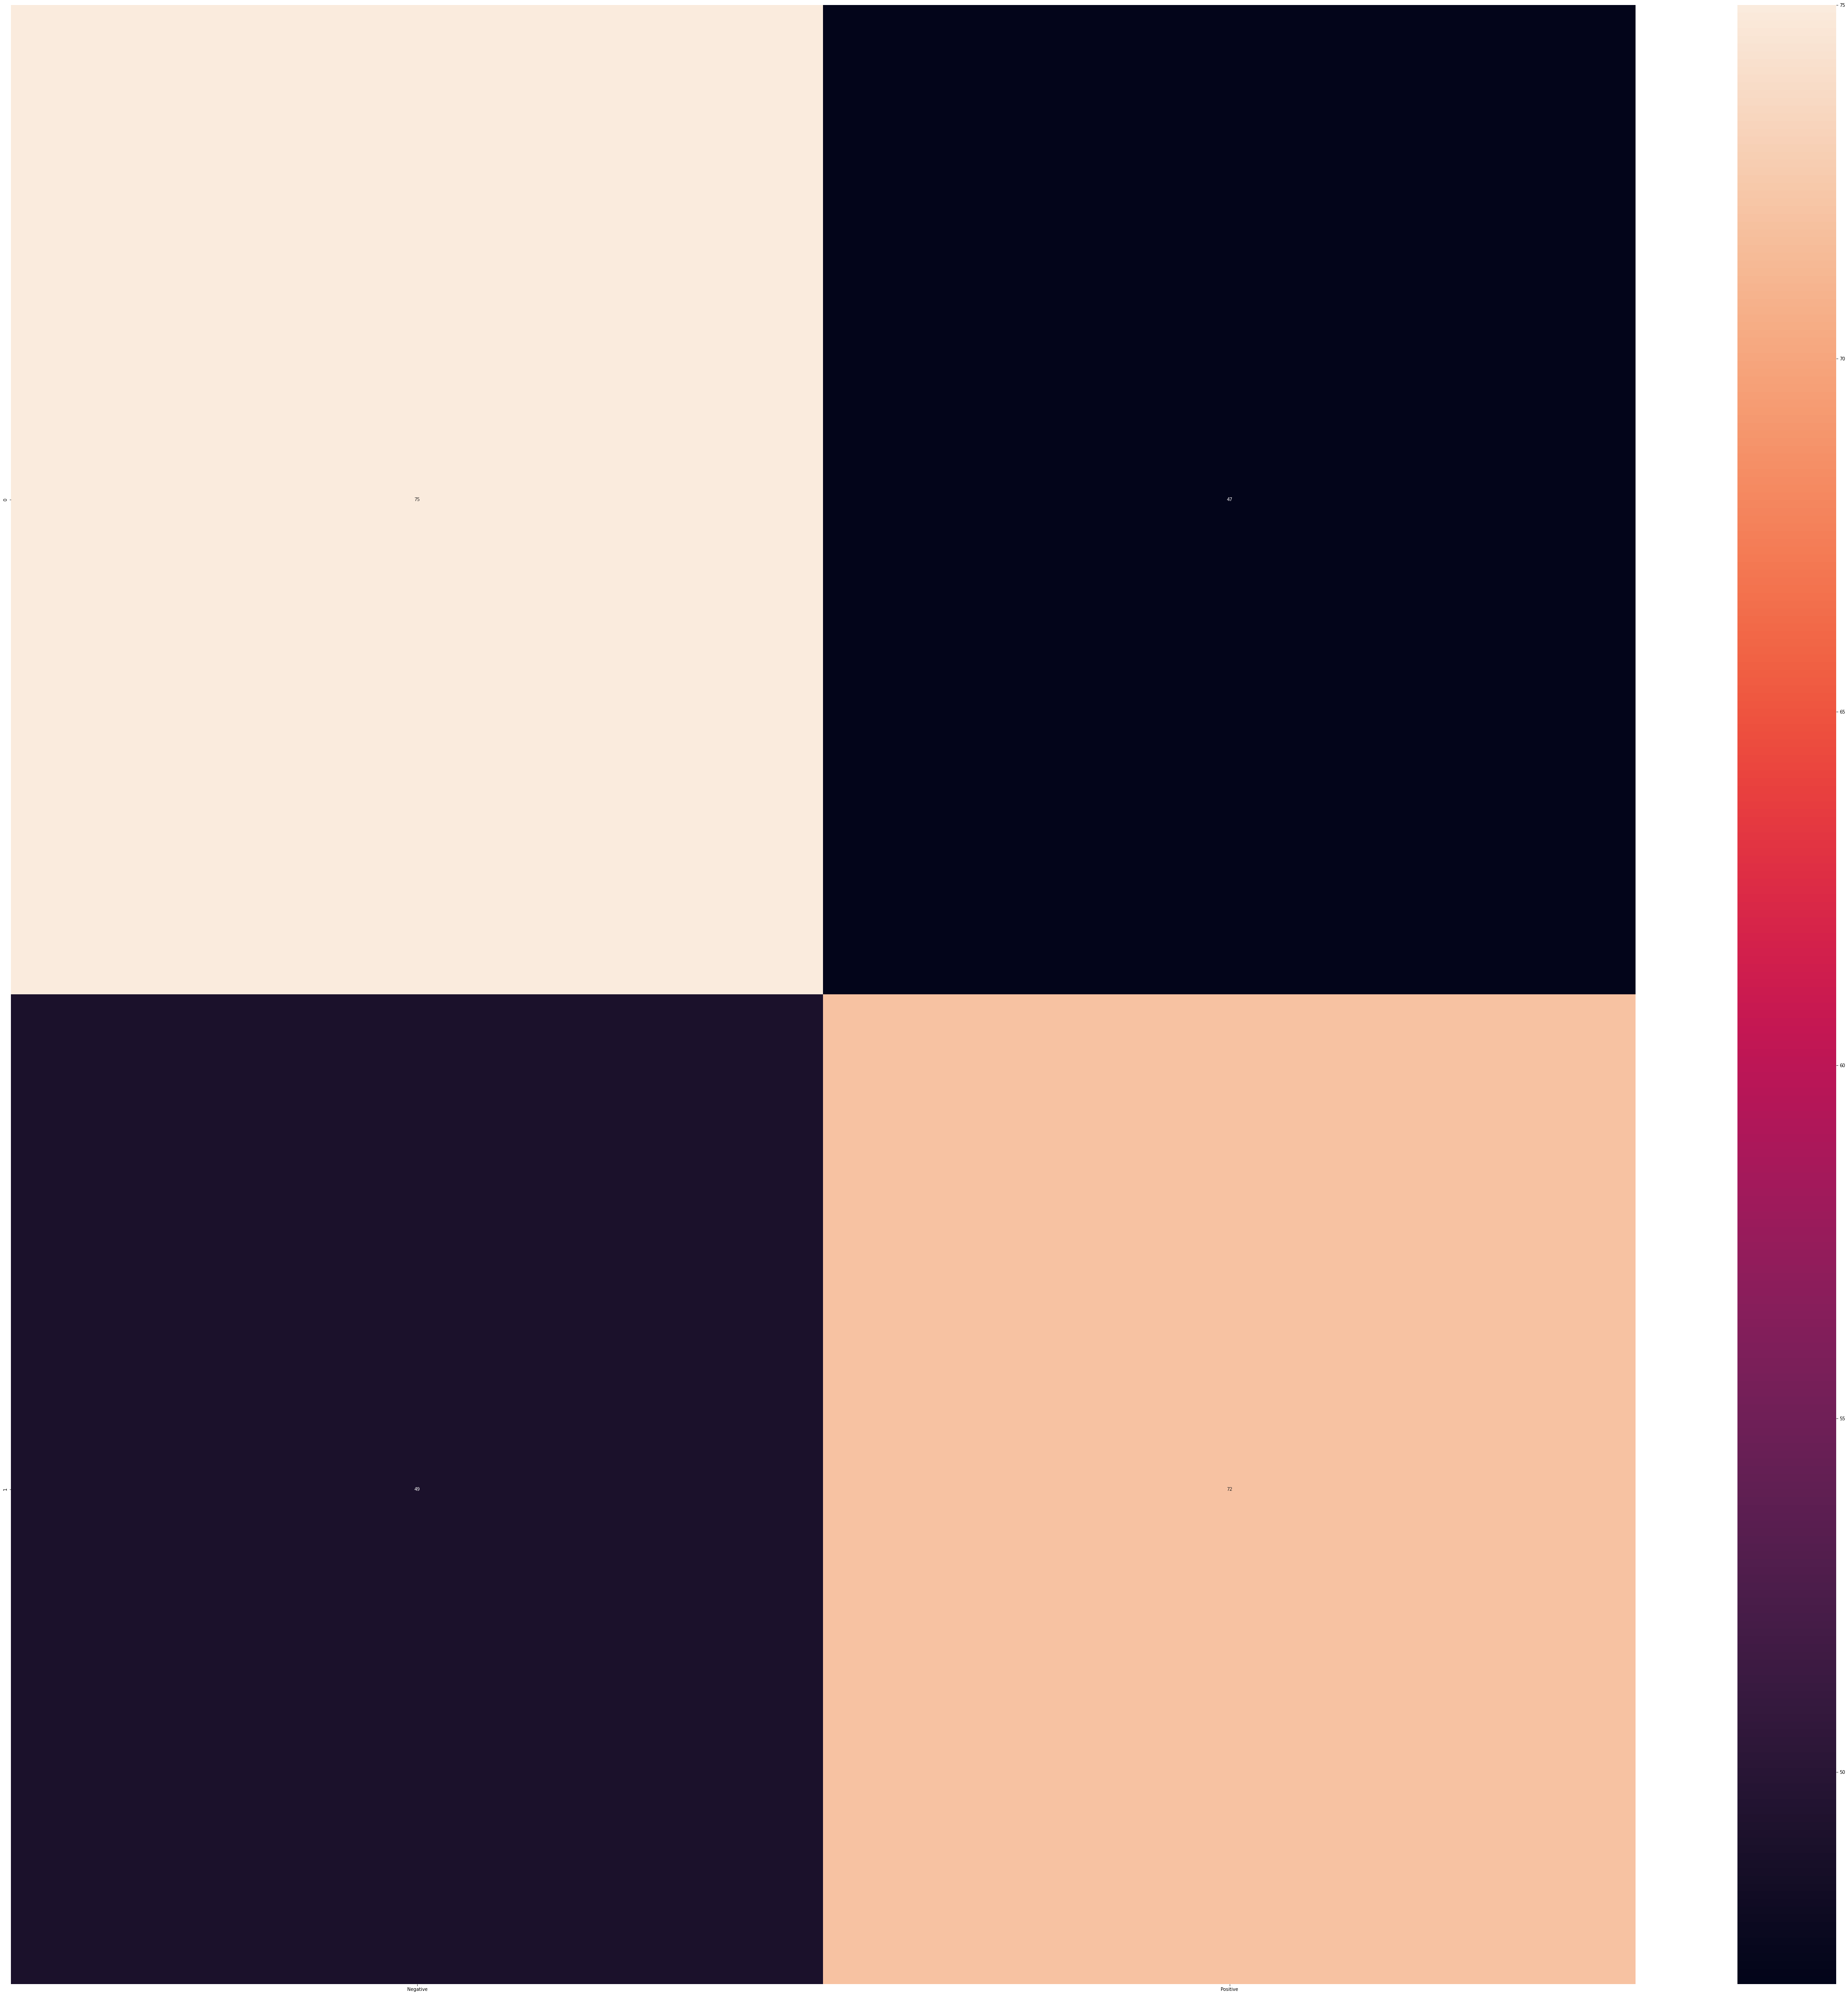

In [13]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y)
df = pd.DataFrame(cm, columns=test_generator.class_indices)
plt.figure(figsize=(80,80))
sn.heatmap(df, annot=True)

Reference: 
## Transfer learning with Keras and MobileNet V2
#### https://www.kaggle.com/devang/transfer-learning-with-keras-and-mobilenet-v2/